## Временные ряды

Код из статьи: https://www.dmitrymakarov.ru/intro/time-series/ 

### Анализ временных рядов

#### Импорт данных и работа в библиотеке Pandas

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## 
import seaborn as sns

In [13]:
passengers = pd.read_csv("./data/passengers.csv", index_col = 'Month', parse_dates = True)
passengers.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [42]:
births = pd.read_csv("./data/births.csv", index_col = 'Date', parse_dates = True)
births.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [62]:
births.shape

(365, 1)

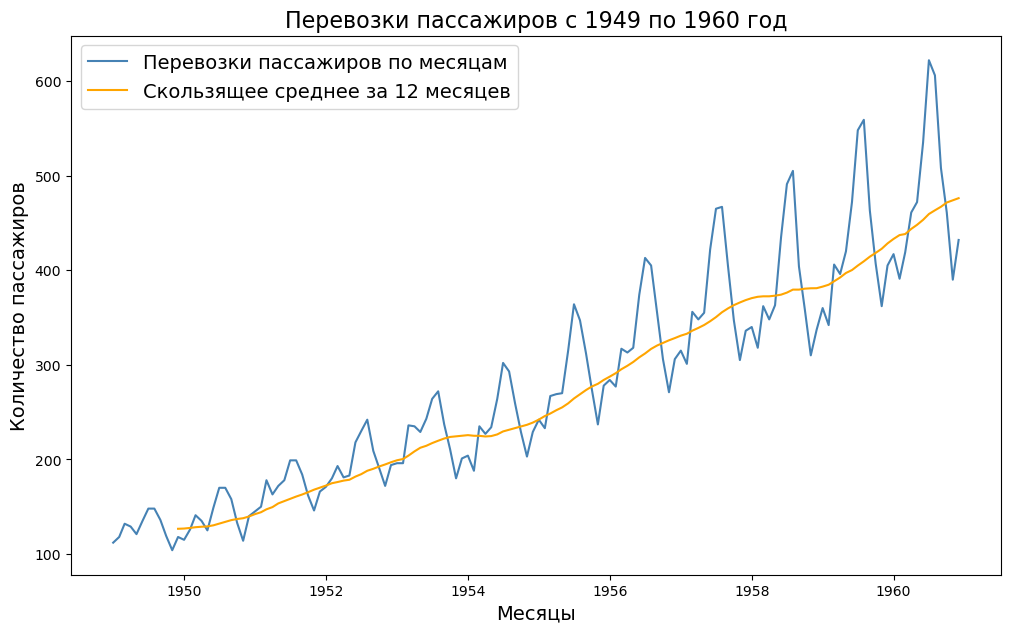

In [33]:
plt.figure(figsize = (12,7))

plt.plot(passengers, label = 'Перевозки пассажиров по месяцам', color = 'steelblue')
plt.plot(passengers.rolling(window = 12).mean(), label = 'Скользящее среднее за 12 месяцев', color = 'orange')

plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Количество пассажиров', fontsize = 14)
plt.title('Перевозки пассажиров с 1949 по 1960 год', fontsize = 16)

plt.show()

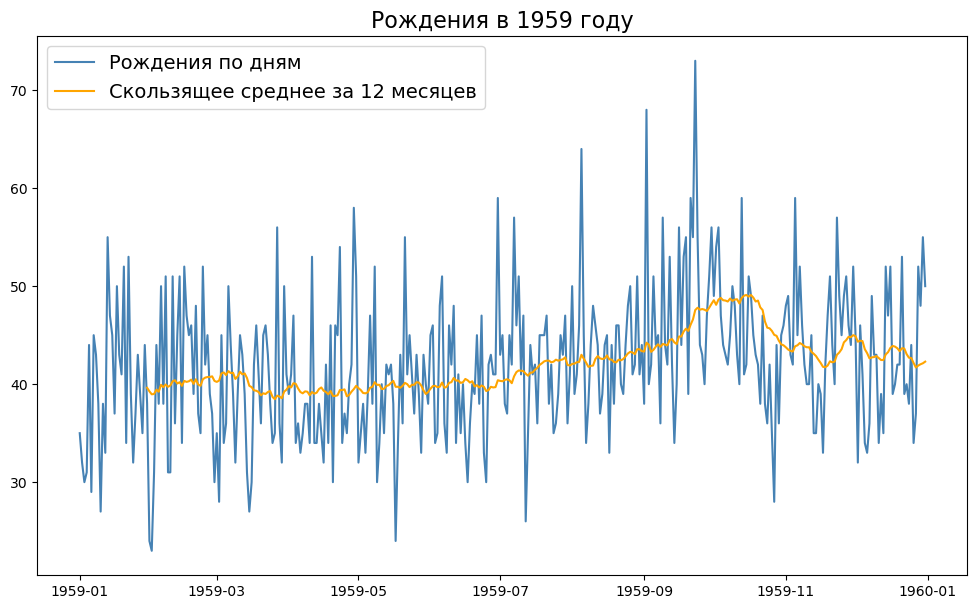

In [64]:
plt.figure(figsize = (12,7))

plt.plot(births, label = 'Рождения по дням', color = 'steelblue')
plt.plot(births.rolling(window = 30).mean(), label = 'Скользящее среднее за 12 месяцев', color = 'orange')

plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.title('Рождения в 1959 году', fontsize = 16)

plt.show()

#### Разложение временного ряда на компоненты

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

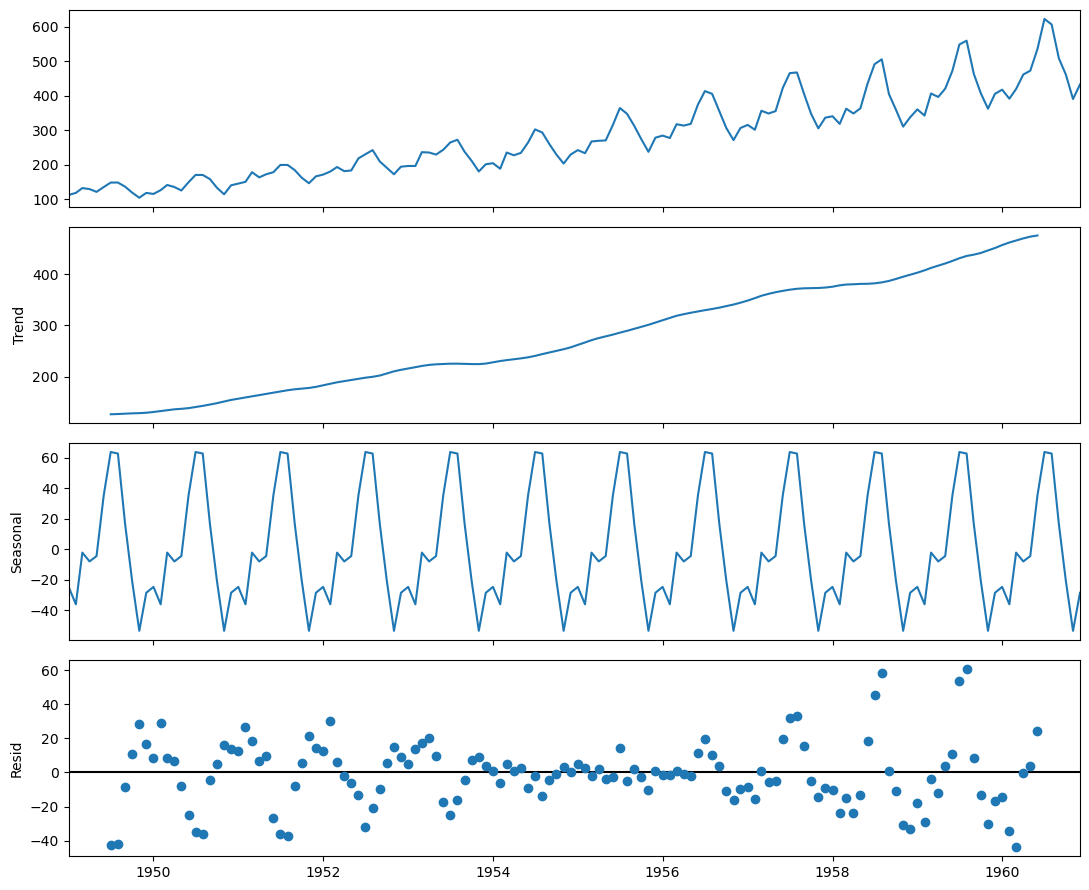

In [70]:
# применяем функцию к данным о перевозках
decompose = seasonal_decompose(passengers)
decompose.plot()

plt.show()

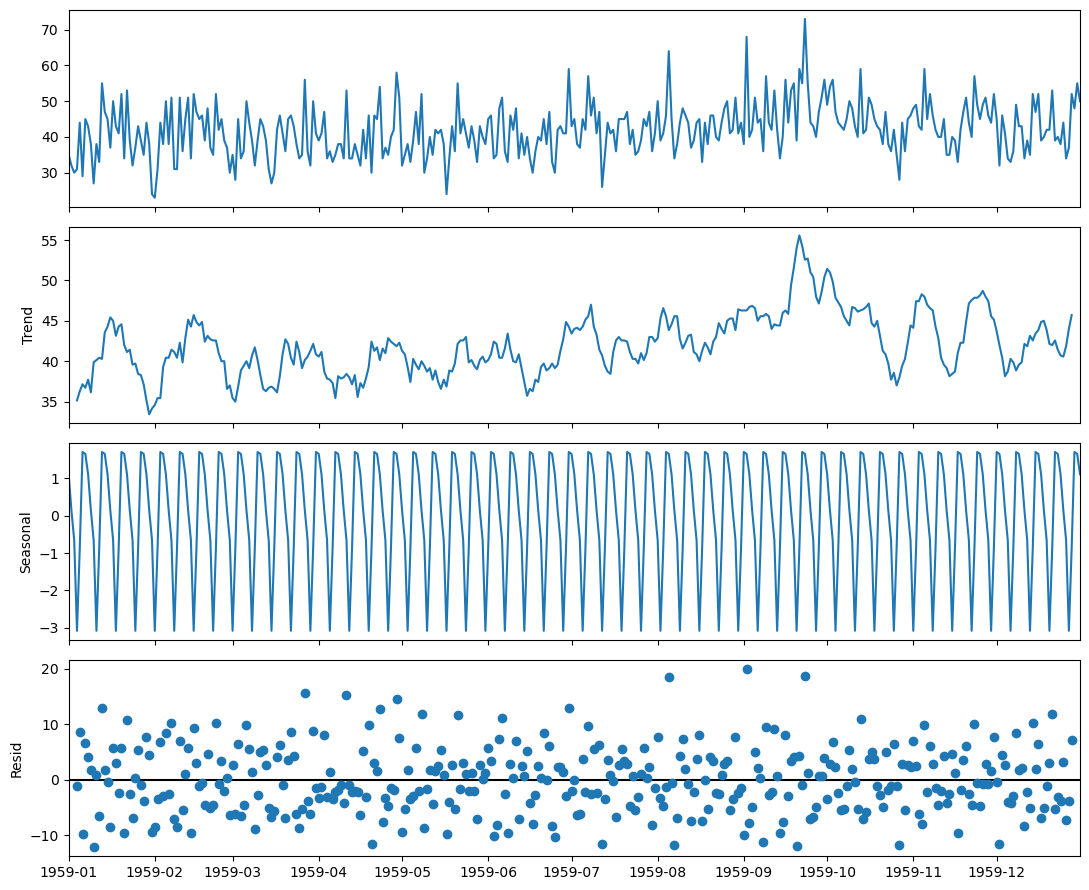

In [72]:
# сделаем то же самое для данных о рождаемости
decompose = seasonal_decompose(births)
decompose.plot()

plt.show()

#### Проверка временного ряда на стационарность

In [ ]:
# проведем тест Дики-Фуллера (Dickey-Fuller test)

# импортируем необходимую функцию
from statsmodels.tsa.stattools import adfuller

# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(passengers['#Passengers'])

# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.991880243437641


In [ ]:
# теперь посмотрим на данные о рождаемости
adf_test = adfuller(births['Births'])

# выведем p-value
print('p-value = ' +str(adf_test[1]))

p-value = 5.2434129901498554e-05


#### Автокорреляция

In [ ]:
# для начала возьмем искусственные данные
data = np.array([16, 21, 15, 24, 18, 17, 20])

# для сдвига на одно значение достаточно взять этот ряд, начиная со второго элемента
lag_1 = data[1:]

# посчитаем корреляцию для лага 1 (у исходных данных мы убрали последний элемент)
# так как мы получим коррелационную матрицу, возьмем первую строку и второй столбец [0, 1]
np.round(np.corrcoef(data[:-1], lag_1)[0,1], 2)

-0.71

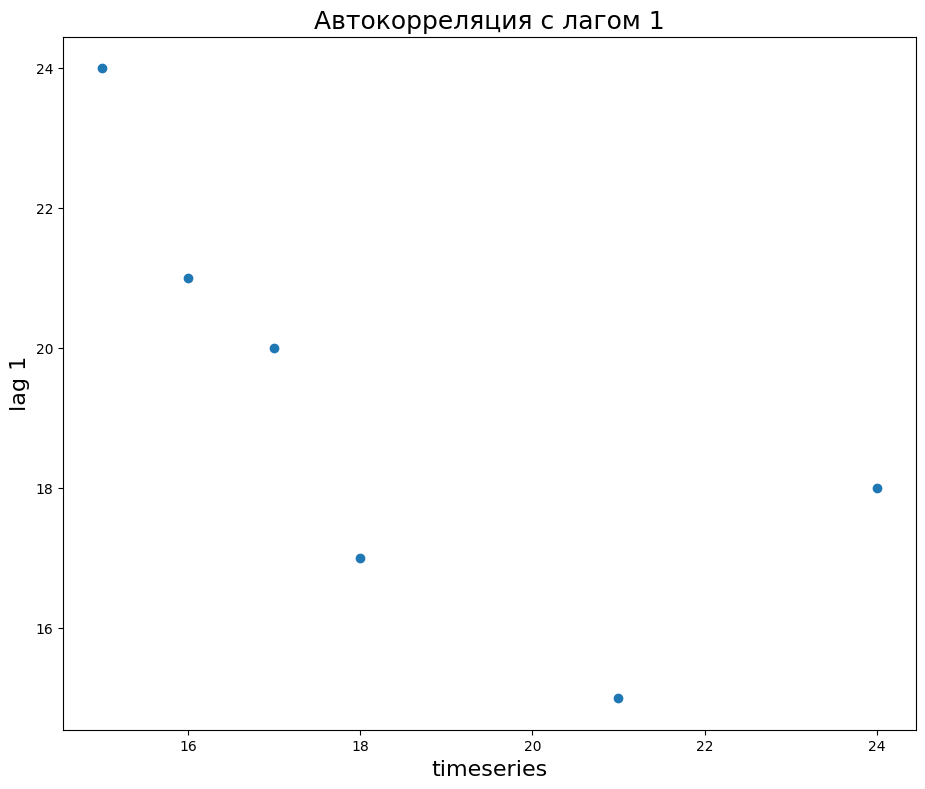

In [ ]:
# построим точечную диаграмму
plt.scatter(data[:-1], lag_1)

# добавим подписи
plt.xlabel('timeseries', fontsize = 16)
plt.ylabel('lag 1', fontsize = 16)
plt.title('Автокорреляция с лагом 1', fontsize = 18)

plt.show()

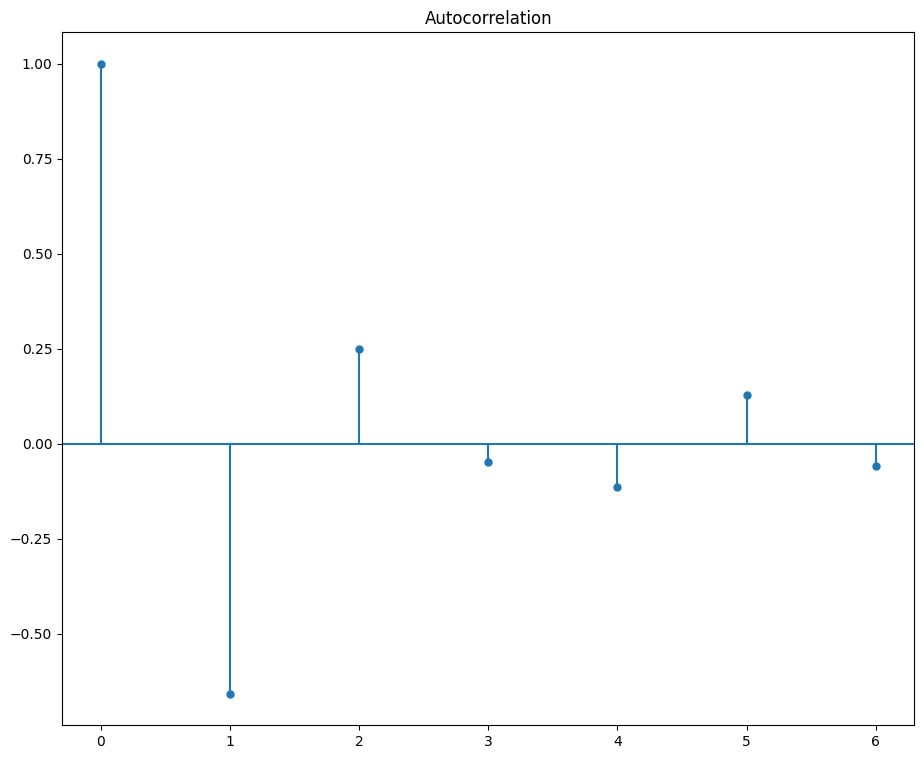

In [ ]:
# импортируем автокорреляционную функцию (ACF)
from statsmodels.graphics.tsaplots import plot_acf

# применим функцию к набору данных
plot_acf(data, lags = np.arange(len(data)), alpha = None)

# добавим отступы сверху и снизу на графике
plt.axis('tight')
plt.show()

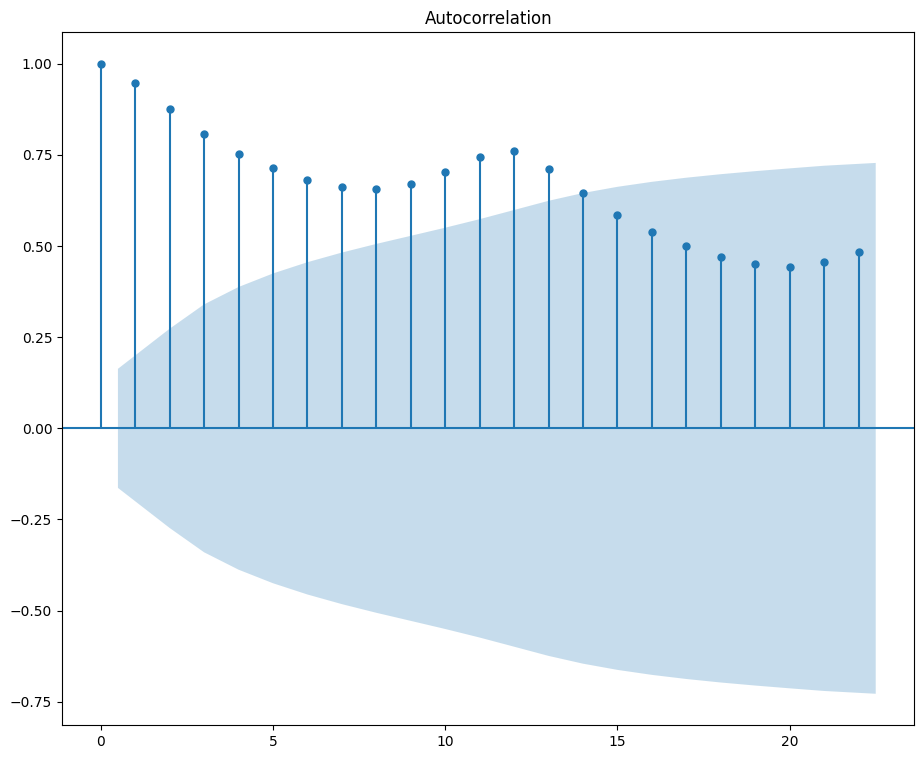

In [ ]:
# применим ее к данным о пассажирах
plot_acf(passengers)
plt.axis('tight')
plt.show()

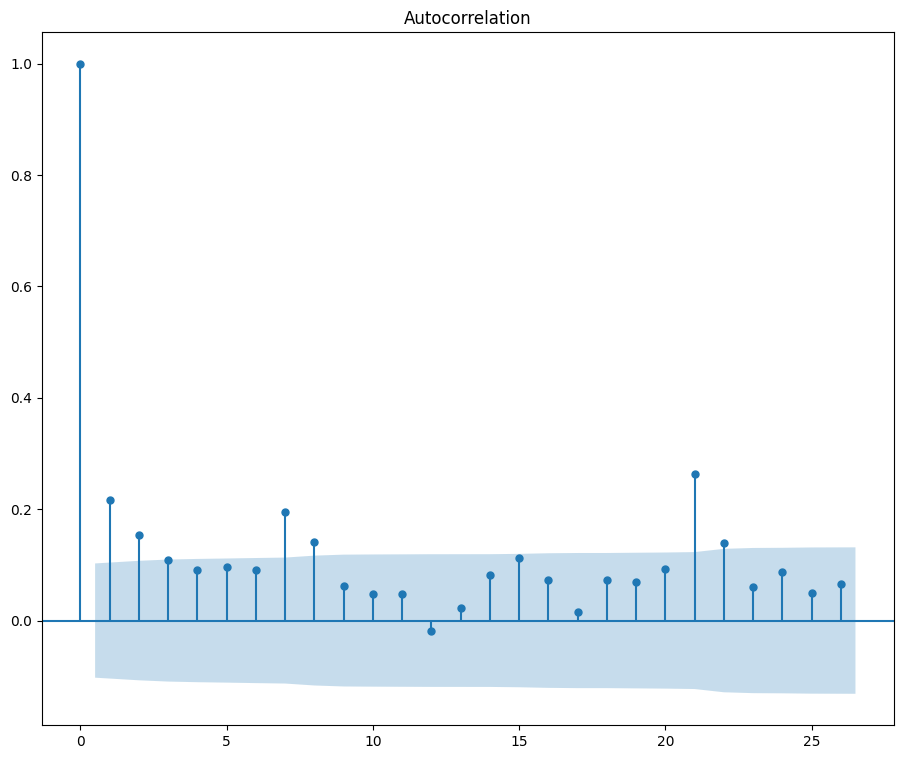

In [ ]:
# построим аналогичный график для данных о рождаемости
plot_acf(births)
plt.axis('tight')
plt.show()

### Моделирование и построение прогноза

#### Экспоненциальное сглаживание

In [ ]:
births['Births'].iloc[0]

35

In [ ]:
alpha = 0.2

# первое значение совпадает со значением временного ряда
exp_smoothing = [births['Births'].iloc[0]]

# в цикле for последовательно применяем формулу ко всем элементам ряда
for i in range(1, len(births['Births'])):
  exp_smoothing.append(alpha * births['Births'].iloc[i] + (1 - alpha) * exp_smoothing[i - 1])

# выведем прогнозное значение для 366-го дня (1 января 1960 года)
exp_smoothing[-1]

46.6051933602952

In [ ]:
# посмотрим на количество фактических и прогнозных значений
len(births), len(exp_smoothing)

(365, 365)

In [ ]:
# добавим кривую сглаживаия в качестве столбца в датафрейм
births['Exp_smoothing'] = exp_smoothing
births.tail(3)

,Births,Exp_smoothing
Date,,
1959-12-29,48,43.445615
1959-12-30,55,45.756492
1959-12-31,50,46.605193


In [ ]:
# теперь нужно сдвинуть второй столбец на один день вперед (ведь это прогноз)

# вначале создадим индекс за 1 января

# для этого импортируем класс timedelta
from datetime import timedelta

# возьмём последний индекс (31 декабря 1959 года)
last_date = births.iloc[[-1]].index

# # "прибавим" один день
last_date = last_date + timedelta(days = 1)
last_date

DatetimeIndex(['1960-01-01'], dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
# добавим его в датафрейм
births = pd.concat([births, pd.DataFrame(index = last_date)])

# значения за этот день останутся пустыми
births.tail()

,Births,Exp_smoothing
Date,,
1959-12-28,52.0,42.307018
1959-12-29,48.0,43.445615
1959-12-30,55.0,45.756492
1959-12-31,50.0,46.605193
1960-01-01,NaN,NaN


In [ ]:
# сдвинем этот столбец на один день вперед
births['Exp_smoothing'] = births['Exp_smoothing'].shift(1)

In [ ]:
# как и должно быть, первое прогнозное значение совпадает с предыдущим фактическим
births.head()

,Births,Exp_smoothing
Date,,
1959-01-01,35.0,NaN
1959-01-02,32.0,35.000
1959-01-03,30.0,34.400
1959-01-04,31.0,33.520
1959-01-05,44.0,33.016


In [ ]:
# и у нас есть прогноз на один день вперед
births.tail()

,Births,Exp_smoothing
Date,,
1959-12-28,52.0,39.883773
1959-12-29,48.0,42.307018
1959-12-30,55.0,43.445615
1959-12-31,50.0,45.756492
1960-01-01,NaN,46.605193


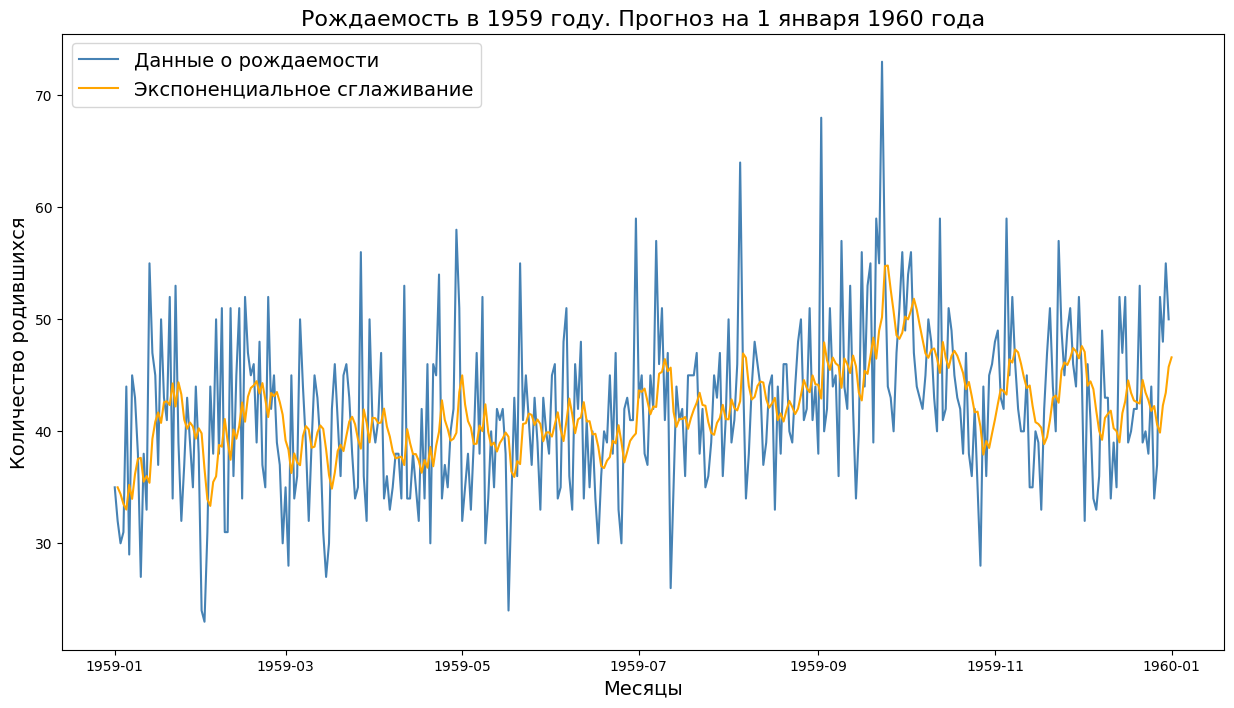

In [ ]:
# посмотрим на результат на графике

# зададим размер
plt.figure(figsize = (15,8))

# выведем данные о рождаемости и кривую экспоненциального сглаживания
plt.plot(births['Births'], label = 'Данные о рождаемости', color = 'steelblue')
plt.plot(births['Exp_smoothing'], label = 'Экспоненциальное сглаживание', color = 'orange')

# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)

# добавим подписи к осям и заголовки
plt.ylabel('Количество родившихся', fontsize = 14)
plt.xlabel('Месяцы', fontsize = 14)
plt.title('Рождаемость в 1959 году. Прогноз на 1 января 1960 года', fontsize = 16)

plt.show()

#### Модель SARIMAX

In [ ]:
# разобьём данные на обучающую и тестовую выборки

# обучающая выборка будет включать данные до декабря 1959 года включительно
train = passengers[:'1959-12']

# тестовая выборка начнется с января 1960 года (по сути, один год)
test = passengers['1960-01':]

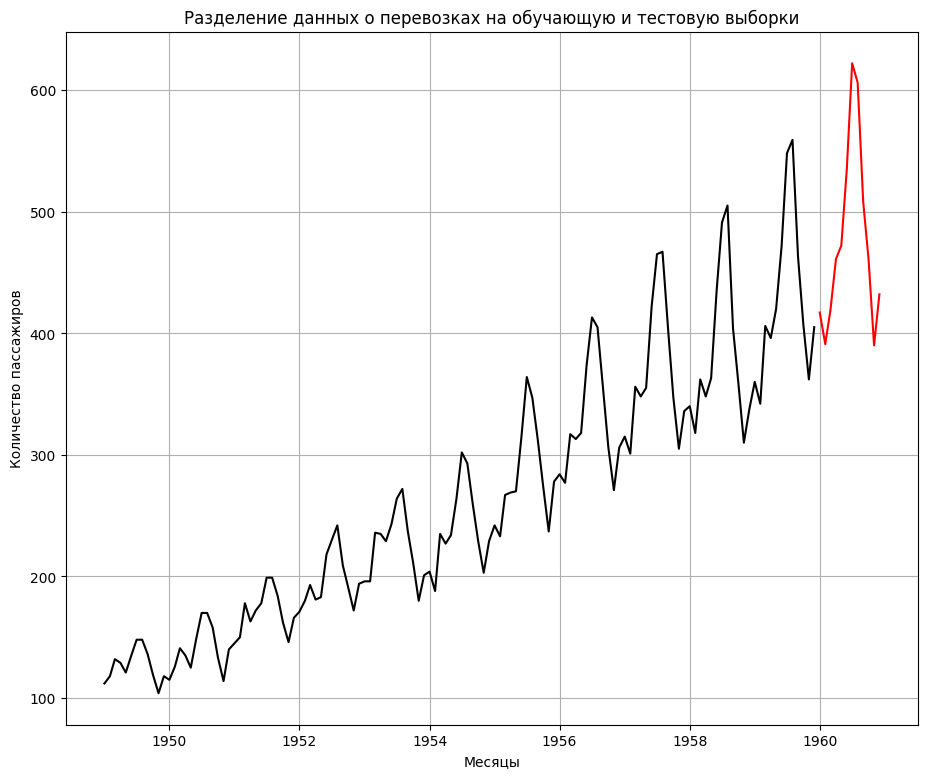

In [ ]:
# выведем эти данные на графике
plt.plot(train, color = "black")
plt.plot(test, color = "red")

# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [ ]:
# принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

# обучим модель с соответствующими параметрами, SARIMAX(3, 0, 0)x(0, 1, 0, 12)

# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX

# создадим объект этой модели
model = SARIMAX(train,
                order = (3, 0, 0),
                seasonal_order = (0, 1, 0, 12))

# применим метод .fit()
result = model.fit()

In [ ]:
# мы можем посмотреть результат с помощью метода summary()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -451.953
Date:                            Mon, 10 Mar 2025   AIC                            911.907
Time:                                    11:50:05   BIC                            923.056
Sample:                                01-01-1949   HQIC                           916.435
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7603      0.088      8.672      0.000       0.588       0.932
ar.L2          0.2875      0.133   

In [ ]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)

# и закончится в конце тестового
end = len(train) + len(test) - 1

# применим метод .predict()
predictions = result.predict(start, end)
predictions

,predicted_mean
1960-01-01,422.703385
1960-02-01,404.947178
1960-03-01,466.293258
1960-04-01,454.781296
1960-05-01,476.848628
1960-06-01,527.162826
1960-07-01,601.449809
1960-08-01,610.821691
1960-09-01,513.229987
1960-10-01,455.692619


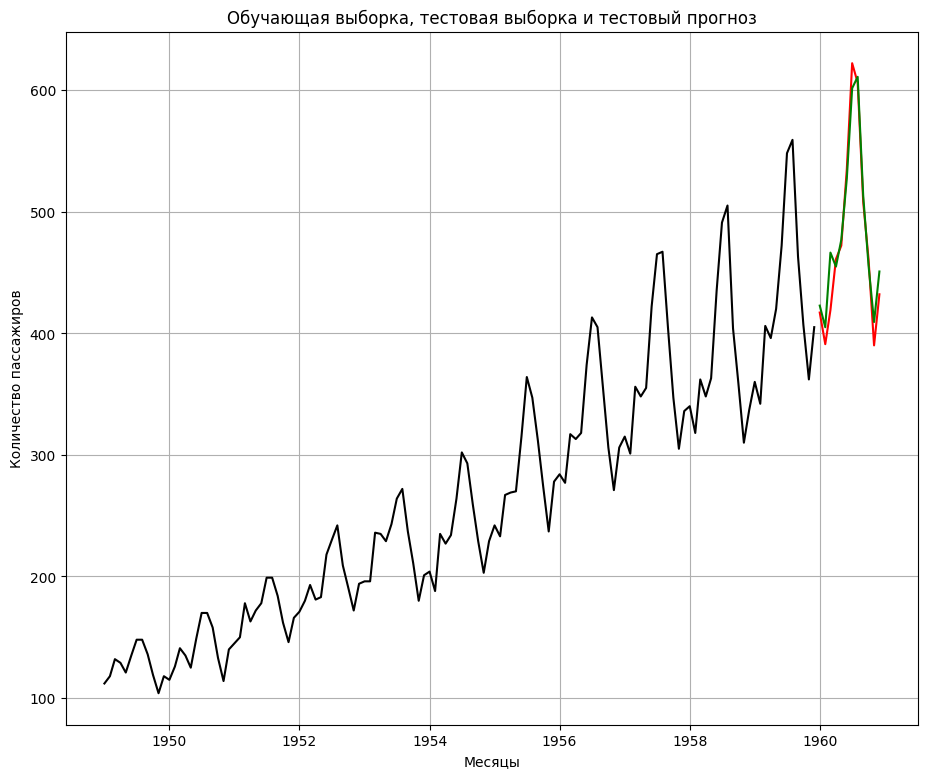

In [ ]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train, color = 'black')
plt.plot(test, color = 'red')
plt.plot(predictions, color = 'green')

# заголовок и подписи к осям
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [ ]:
# импортируем функции метрик
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# рассчитаем MSE
print(mean_squared_error(test, predictions))

# и RMSE
print(root_mean_squared_error(test, predictions))

317.39565432961956
17.81560143047715


In [ ]:
# прогнозный период начнется с конца имеющихся данных
start = len(passengers)

# и закончится 36 месяцев спустя
end = (len(passengers) - 1) + 3 * 12

# теперь построим прогноз на три года вперед
forecast = result.predict(start, end)

# посмотрим на весь 1963 год
forecast[-12:]

,predicted_mean
1963-01-01,518.603436
1963-02-01,497.908988
1963-03-01,556.406784
1963-04-01,542.133835
1963-05-01,561.524762
1963-06-01,609.244563
1963-07-01,681.016637
1963-08-01,687.950665
1963-09-01,587.995801
1963-10-01,528.167677


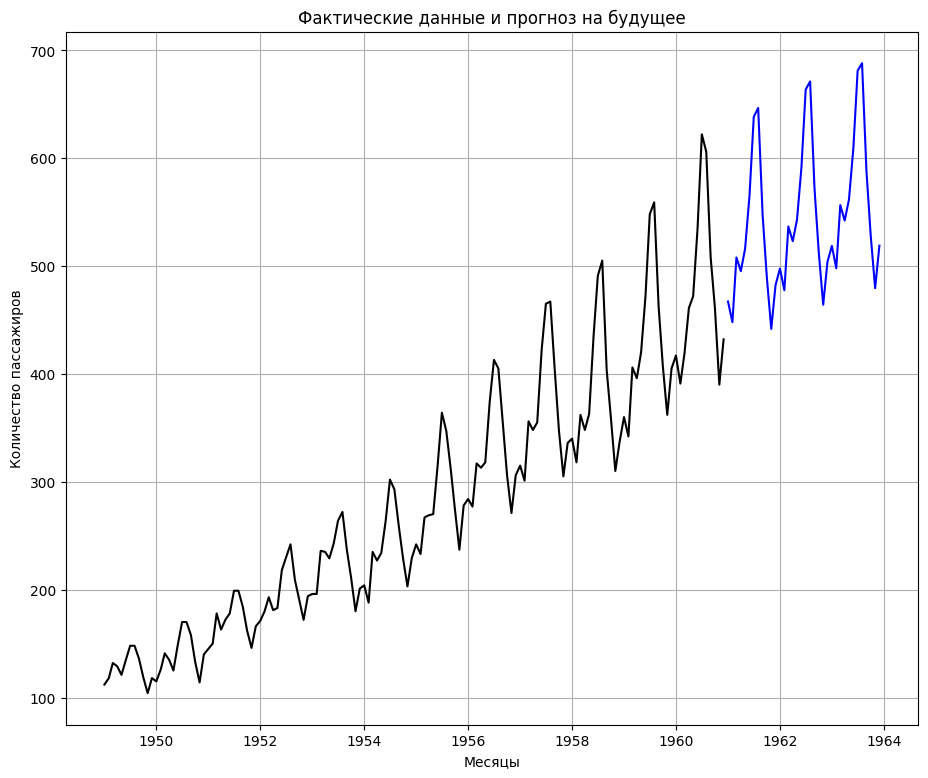

In [ ]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.plot(passengers, color = 'black')
plt.plot(forecast, color = 'blue')

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

### Дополнительный материал

In [ ]:
# установим pmdarima
# !pip install pmdarima

In [ ]:
# !pip install statsmodels

In [ ]:
# импортируем функцию для автоматического подбора параметров модели ARIMA
from pmdarima import auto_arima


# "погасим" предупреждения
import warnings
warnings.filterwarnings("ignore")

# настроим поиск параметров на обучающей выборке
parameter_search = auto_arima(train, start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                              m = 12, start_P = 0, seasonal = True,
                              d = None, D = 1, trace = True, error_action ='ignore',
                              suppress_warnings = True,  stepwise = True)

# выведем результат
print(parameter_search.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=907.364, Time=1.49 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=1.87 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=2.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.18 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.28 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=6.13 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.26 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=1.35 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=11.95 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.35 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.60 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.20 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.43 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   